In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.interpolate
import os

In [3]:
from adapt_utils.case_studies.tohoku.options.options import TohokuOptions

# Gauge data for Tohoku tsunami

We have two different types of gauge: GPS gauges and pressure gauges.
In the former case, the observed variable is free surface displacement.
In the latter case, the observed variable is pressure.

We deduce free surface elevation from pressure using hydrostatic assumptions:

$$p_{\mathrm{hydrostatic}}=\rho gH,$$

where $\rho\approx1030.0\,\mathrm{kg\,m}^{-3}$ is the density of sea water, $g\approx9.81\,\mathrm{m\,s}^{-2}$ is gravitational acceleration and $H$ is the height of the fluid column.

The height of the fluid column may be decomposed as

$$H=b + \eta,$$

where the bathymetry $b$ $[\mathrm m]$ is known and $\eta$ $[\mathrm m]$ is the free surface displacement we seek.

_[These calculations are performed on the raw data using_ `preproc.py`. _This outputs the_ `.dat` _files found in the git repo.]_

## <u> The data </u>

First let's take a look at what the data looks like once it has been converted into appropriate units.
We (loosely) categorise the gauges based on their distance from the earthquake epicentre.

In [4]:
op = TohokuOptions()

In [5]:
def plot_data(gauges):
    n = len(gauges)
    fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))
    for i, gauge in enumerate(gauges):
        axes[i].plot(*op.extract_data(gauge), label=gauge)
        axes[i].set_xlabel("Time [s]")
        axes[i].set_ylabel("Elevation [m]")
        axes[i].legend()

### Near field GPS gauges

First consider the data from GPS gauges, each of which is located close to the east coast of Japan.

These data are the cleanest, with only a short sequence of observation errors shortly after the earthquake (encoded as `NaN`s).

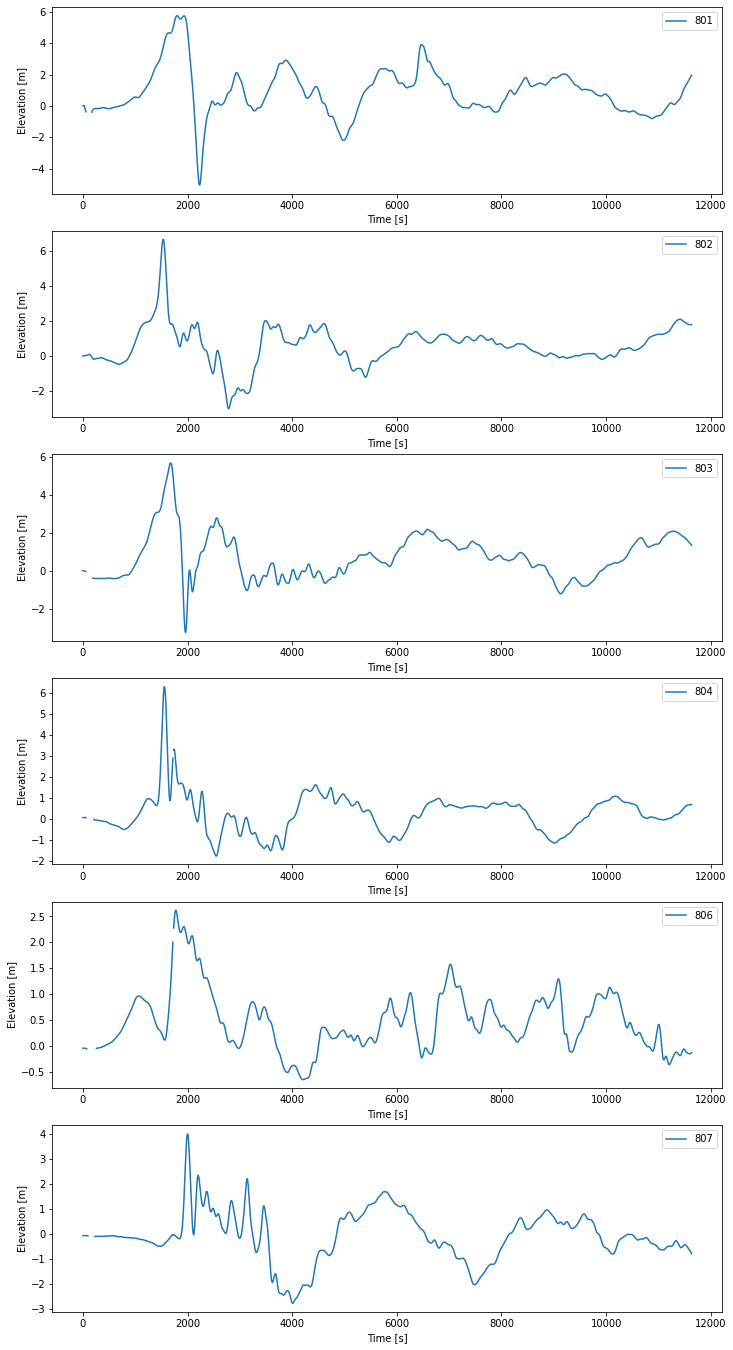

In [6]:
plot_data(op.near_field_gps_gauges["gauges"])

### Near field pressure gauges

Next consider the temporary pressure gauges P02 and P06 which were operated by Tohoku University.
These gauges were within the tsunami source region and hence registered a significant signal.
We see that there is a lot of noise in this data, likely due to the earthquake which just struck nearby!

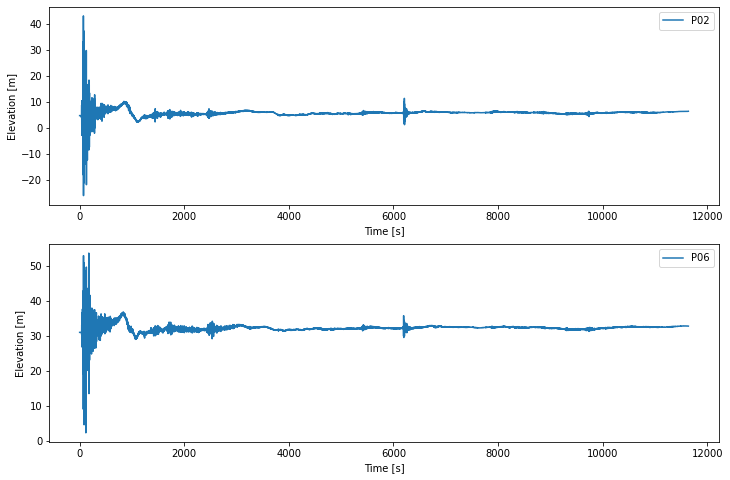

In [7]:
plot_data(op.near_field_pressure_gauges["gauges"])

### Mid field pressure gauges

Next consider two gauges to the north of the tsunami source, operated by the Japanese Agency for Marine-Earth Science and Technology (JAMSTEC), as well as a fairly near-field DART gauge.

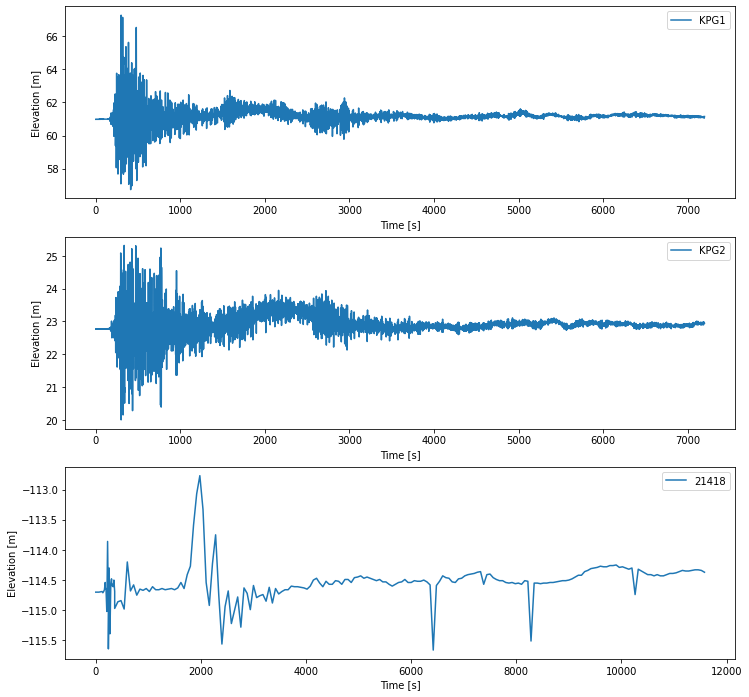

In [8]:
plot_data(op.mid_field_pressure_gauges["gauges"])

### Far field GPS gauges

PARI also provides GPS gauge data which is further down the east coast of Japan.
These gauges are somewhat shielded from the tsunami by the surrounding coast.

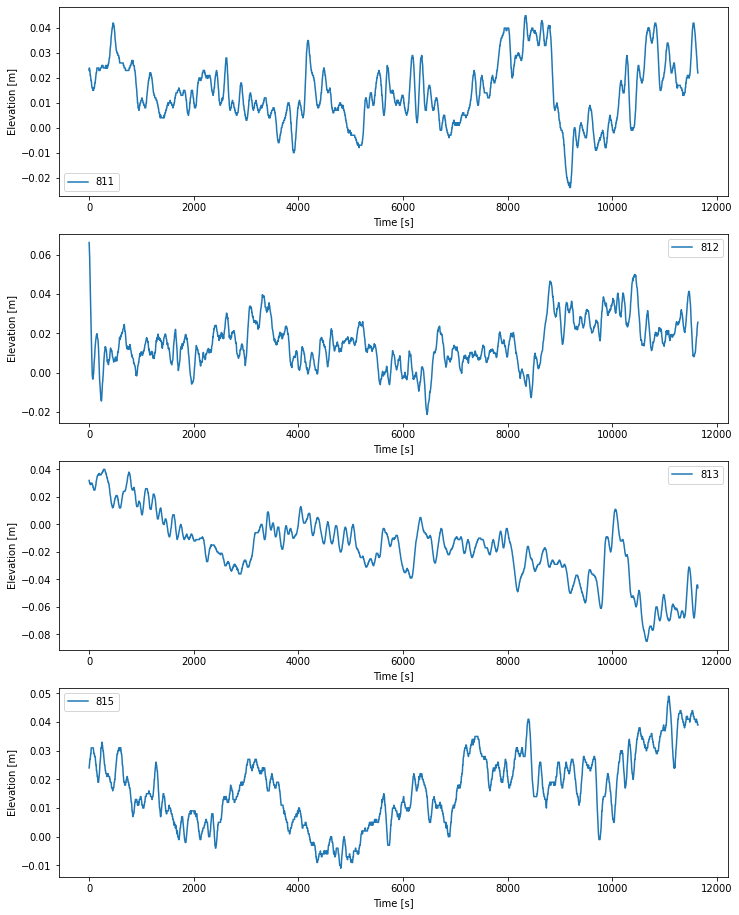

In [9]:
plot_data(op.far_field_gps_gauges["gauges"])

It doesn't look like these gauges will be of much use...

### Far field pressure gauges

Finally, consider the other DART pressure gauges out in the Pacific which are operated by the US National Oceanic and Atmospheric Administration (NOAA).

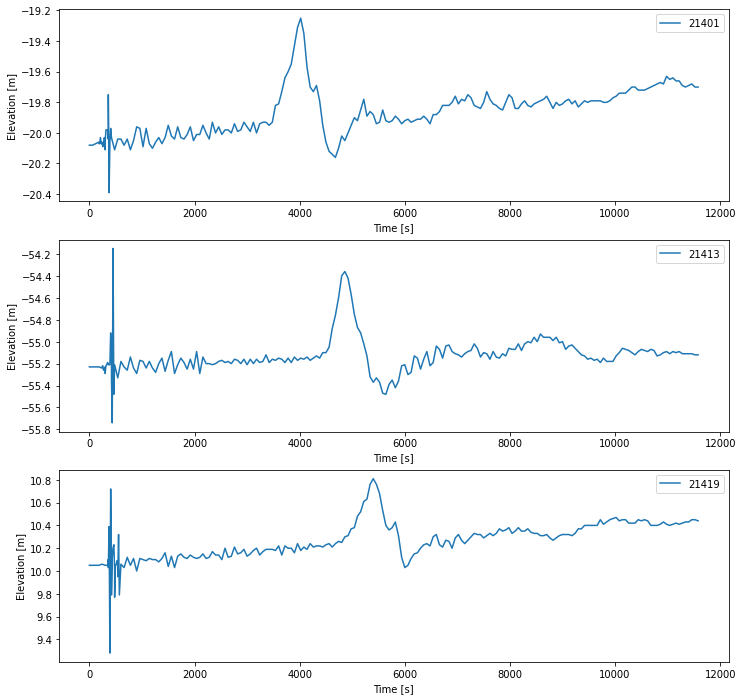

In [10]:
plot_data(op.far_field_pressure_gauges["gauges"])

## <u> De-tiding </u>

These data, of course, include tides.
They are most noticeable in the DART gauge data, where there is a visible underlying trend to the timeseries.

We would like to remove the effect of tides, since they will not be present in subsequent numerical simulations.
For the purposes of *de-tiding*, we use `utide`.

In [11]:
def plot_detided(gauges):
    n = len(gauges)
    fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(16, n*3.5))
    for i, gauge in enumerate(gauges):
        time, detided, elev = op.detide(gauge)
        
        # Plot difference
        axes[i, 1].plot(time/60, detided - elev, label=gauge)
        axes[i, 1].set_xlabel("Time [min]")
        axes[i, 1].set_ylabel("Detiding anomaly [m]")
        axes[i, 1].legend()
        
        # Shift to start at zero
        detided[:] -= detided[0]

        # Plot timeseries before and after
        if gauge[0] == "8":
            markevery = 6
        elif gauge[0] == "P" or "PG" in gauge:
            markevery = 30
        elif gauge[0] == "2":
            markevery = 1
        axes[i, 0].plot(time/60, elev, 'x', label=gauge, markevery=markevery)
        axes[i, 0].plot(time/60, detided, label=gauge + " detided")
        axes[i, 0].set_xlabel("Time [min]")
        axes[i, 0].set_ylabel("Elevation [m]")
        axes[i, 0].legend()

### Near field GPS gauges

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


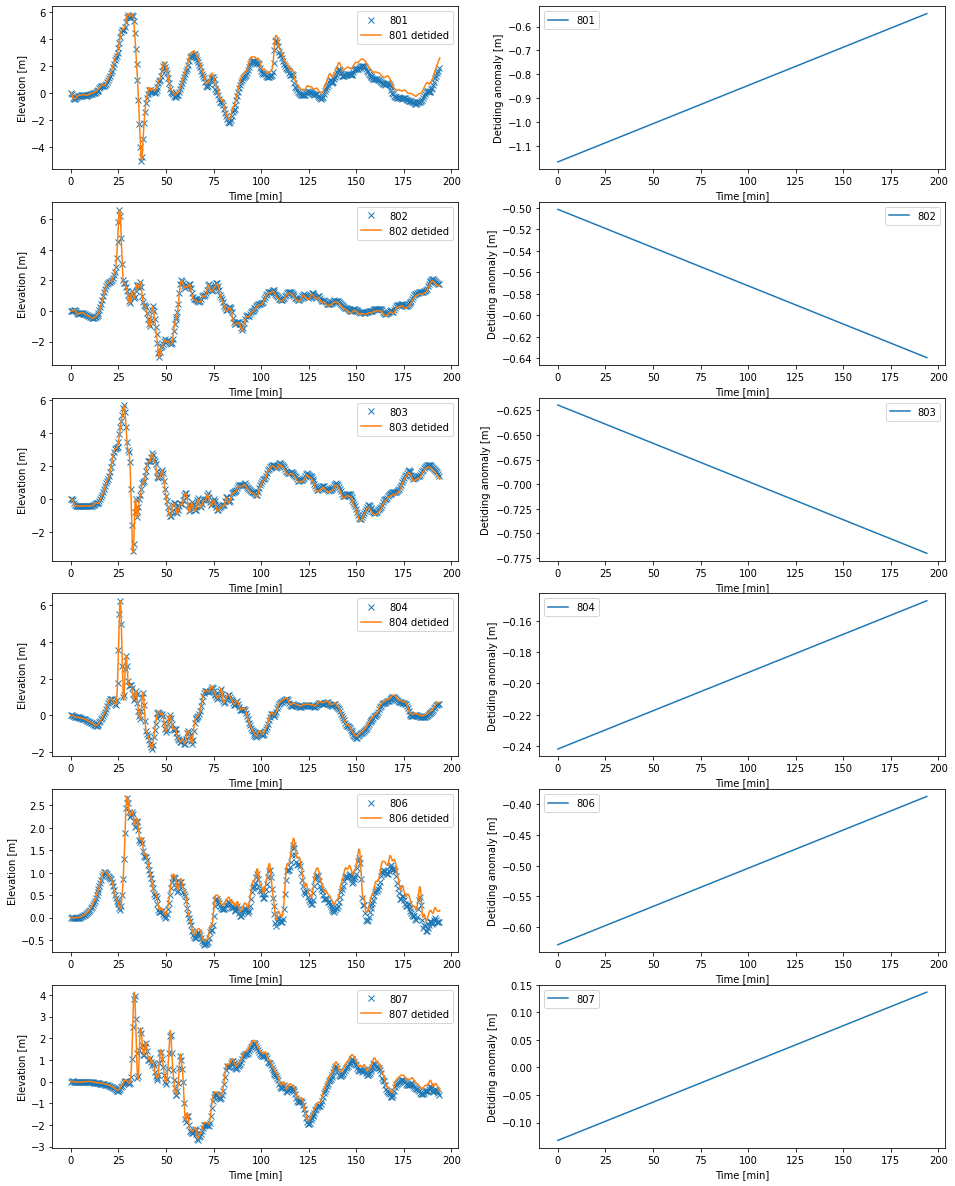

In [12]:
plot_detided(op.near_field_gps_gauges["gauges"])

### Near field pressure gauges

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


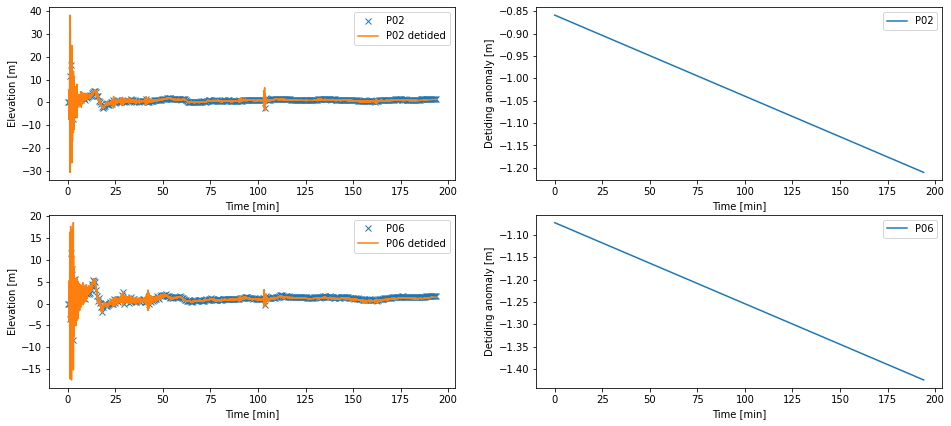

In [13]:
plot_detided(op.near_field_pressure_gauges["gauges"])

### Mid field pressure gauges

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


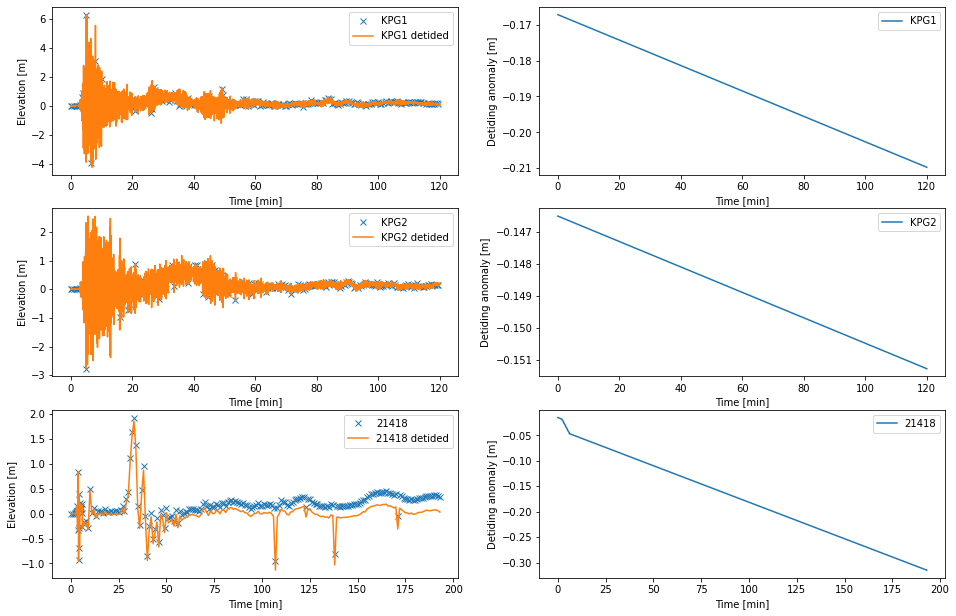

In [14]:
plot_detided(op.mid_field_pressure_gauges["gauges"])

### Far field pressure gauges

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


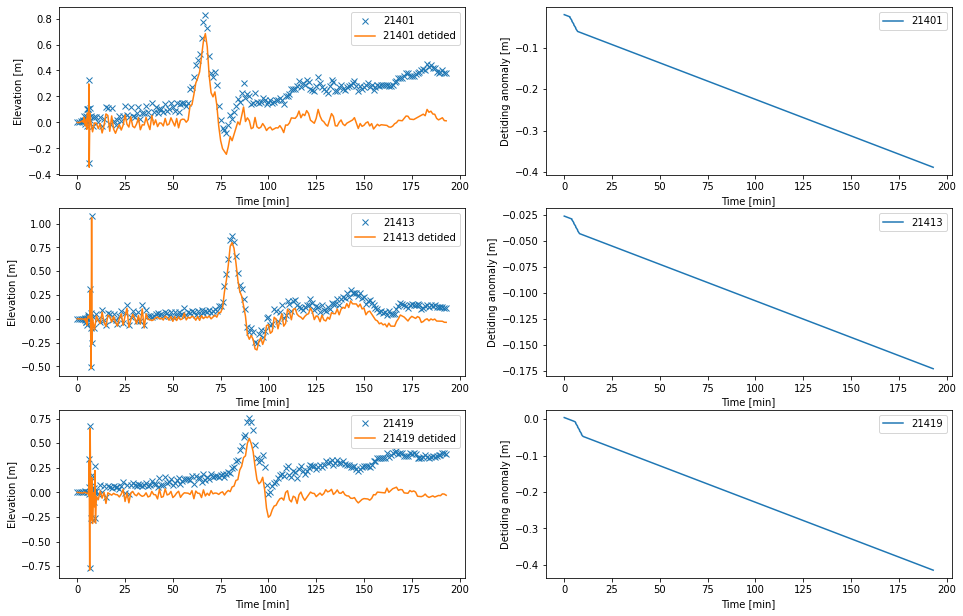

In [15]:
plot_detided(op.far_field_pressure_gauges["gauges"])

## <u> Interpolation and sampling </u>

Finally, we would like to remove some of the noise from the timeseries.

In [16]:
def plot_interpolated_data(gauges, truncate=True, samples=1, plot_data=True, tie_at_start=True):
    n = len(gauges)
    if isinstance(samples, int):
        samples = [samples, ]
    fig, axes = plt.subplots(nrows=n, figsize=(12, n*4))
    for i, gauge in enumerate(gauges):
        ax = axes[i]
        time, detided, elev = op.detide(gauge)

        # Do not consider timeseries before arrival time
        if truncate:
            times = np.array(time[time > op.get_arrival_time(gauge)])
            detided = detided[-len(time):]
        if tie_at_start:
            detided = detided - detided[0]
        if plot_data:
            if gauge[0] == "8":
                markevery = 6
            elif gauge[0] == "P" or "PG" in gauge:
                markevery = 30
            elif gauge[0] == "2":
                markevery = 1
            ax.plot(time/60, detided, label=gauge.upper() + ' (detided)', marker='x', markevery=markevery)

        for sample in samples:
            
            # Get interpolator
#             op.sample_timeseries(gauge, sample=sample, detide=True)
            op.sample_timeseries(gauge, sample=sample, timeseries=detided)  # avoid repeated detidings
            interp = op.gauges[gauge]["interpolator"]

            # Assume start value of zero
            op.gauges[gauge]["data"] = np.array([interp(t) for t in time])
            if tie_at_start:
                op.gauges[gauge]["data"] -= op.gauges[gauge]["data"][0]

            # Plot
            label = gauge.upper() + ' interpolant'
            if sample > 1:
                label += ' (sample {:d})'.format(sample)
            ax.plot(time/60, op.gauges[gauge]['data'], label=label)
            
        ax.set_xlabel("Time [min]");
        ax.set_ylabel("Elevation [m]");
        ax.legend(bbox_to_anchor=(1.1, 0.5));
    return axes

### Near field GPS gauges

For these data, there is no need to sample and so we just compute a piecewise linear interpolant which covers the time period with observation errors.

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


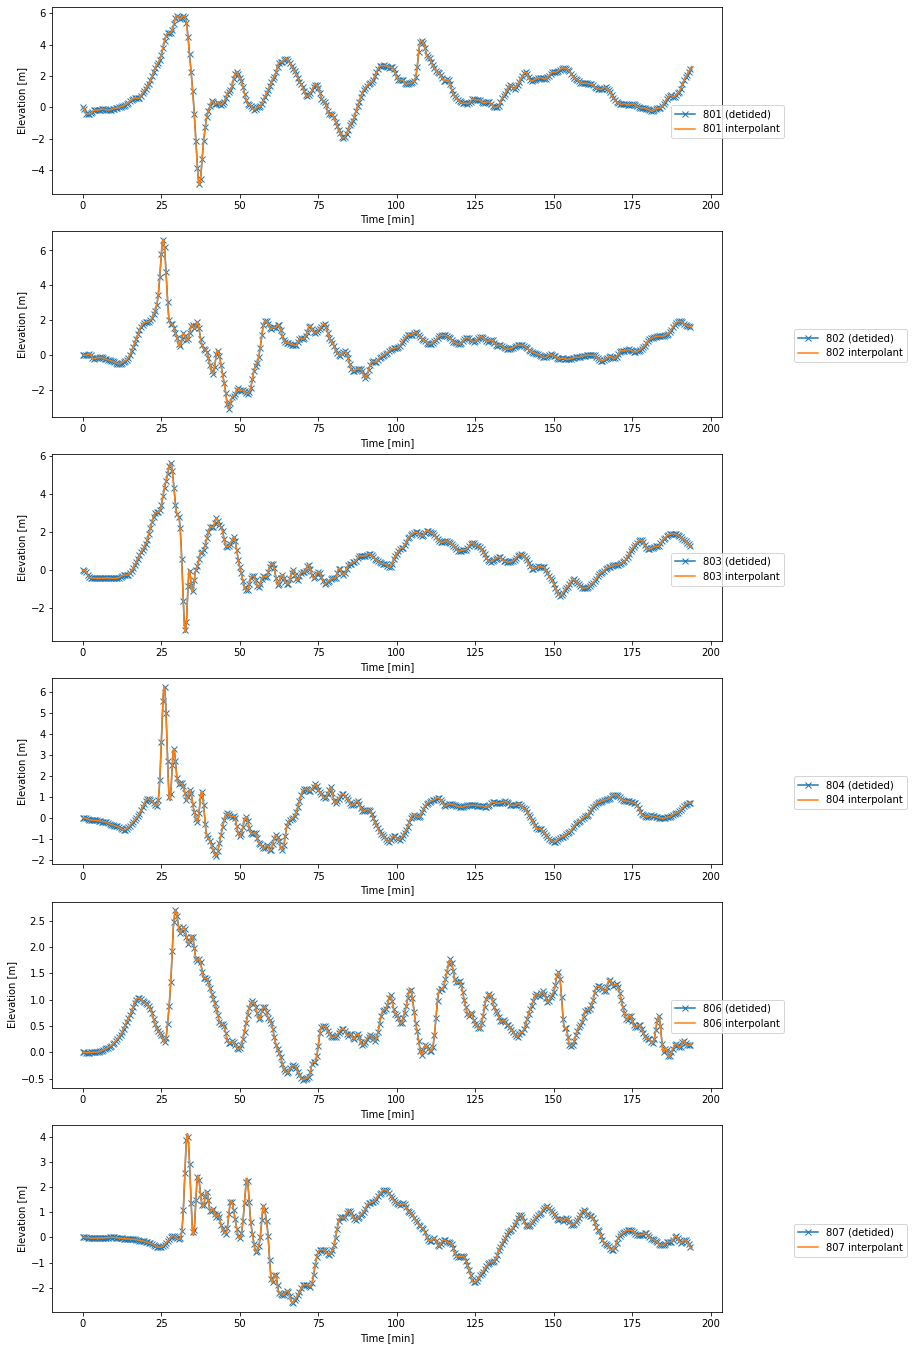

In [17]:
plot_interpolated_data(op.near_field_gps_gauges["gauges"]);

### Near field pressure gauges

Whilst there are no `NaN`s in these data, there is plenty of noise.
It would be beneficial to try and remove this.

From a previous project we also have free surface elevation data extracted from the figure in [Saito et al. 2011] using `PlotDigitizer`.

In [18]:
plot_digitizer = {}
plot_digitizer["P02"] = [
    0.00, 0.07, 0.12, 0.46, 0.85, 1.20, 1.55, 1.90, 2.25, 2.50, 2.80, 3.10, 3.90, 4.80,
    4.46, 2.25, -0.45, -0.17, -1.60, -0.82, -0.44, -0.26, -0.08, 0.13, 0.42, 0.71
]
plot_digitizer["P06"] = [
    0.00, 0.10, 0.30, 0.65, 1.05, 1.35, 1.65, 1.95, 2.25, 2.55, 2.90, 3.50, 4.50, 4.85,
    3.90, 1.55, -0.35, -1.05, -0.65, -0.30, -0.15, 0.05, 0.18, 0.35, 0.53, 0.74
]

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


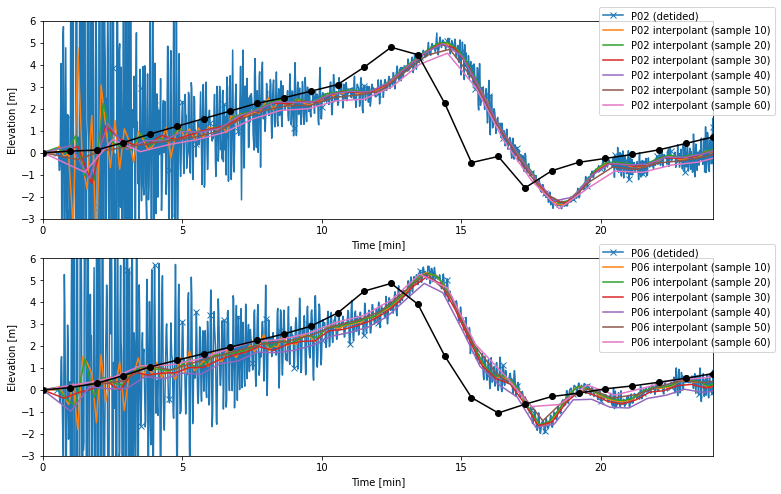

In [19]:
gauges = op.near_field_pressure_gauges["gauges"]
axes = plot_interpolated_data(gauges, samples=[10, 20, 30, 40, 50, 60])
end_time = 24
for ax, gauge in zip(axes, gauges):
    ax.set_xlim([0, end_time])
    ax.set_ylim([-3, 6])
    data = plot_digitizer[gauge]
    N = len(data)
    ax.plot(np.linspace(0, end_time, N), data, marker='o', color='k', label=gauge.title() + ' PlotDigitizer')

It also looks like the converted data and `PlotDigitizer` are out of sync.
Let's try sampling over windows and taking the average for a few different sample sizes and shift the `PlotDigitizer` profile by 90 seconds.

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


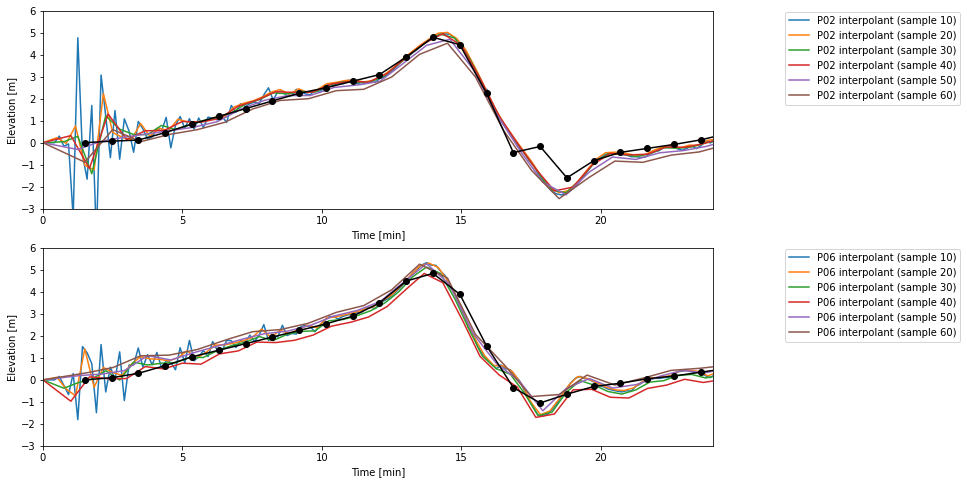

In [20]:
gauges = op.near_field_pressure_gauges["gauges"]
axes = plot_interpolated_data(gauges, samples=[10, 20, 30, 40, 50, 60], plot_data=False, tie_at_start=True)
end_time = 24
for ax, gauge in zip(axes, gauges):
    ax.set_xlim([0, end_time])
    ax.set_ylim([-3, 6])
    data = plot_digitizer[gauge]
    N = len(data)
    ax.plot(np.linspace(0, end_time, N) + 1.5, data, marker='o', color='k', label=gauge.title() + ' PlotDigitizer')

It seems averaging the data over every minute interval is sufficient to reduce the noise to an acceptable level, whilst maintaining the general shape of the profile.

### Mid field pressure gauges

Given that this category contains two different types of gauge, with different observation frequencies, we will probably want to sample them differently.

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


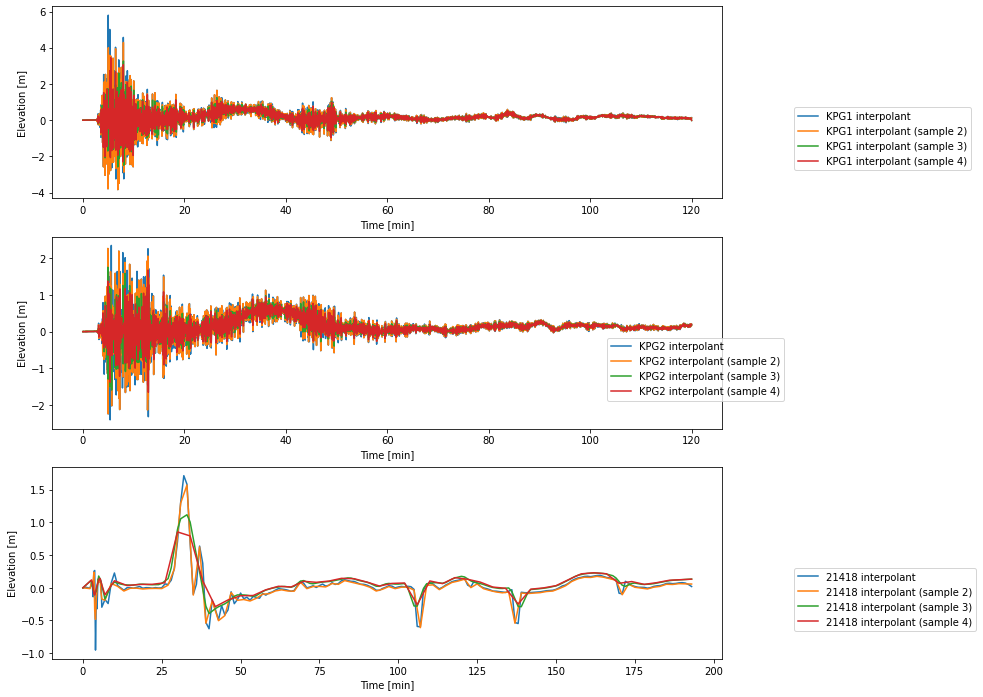

In [21]:
gauges = op.mid_field_pressure_gauges["gauges"]
plot_interpolated_data(gauges, samples=[1, 2, 3, 4], plot_data=False);

As mentioned above, KPG1 and KPG2 will need more sampling.

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


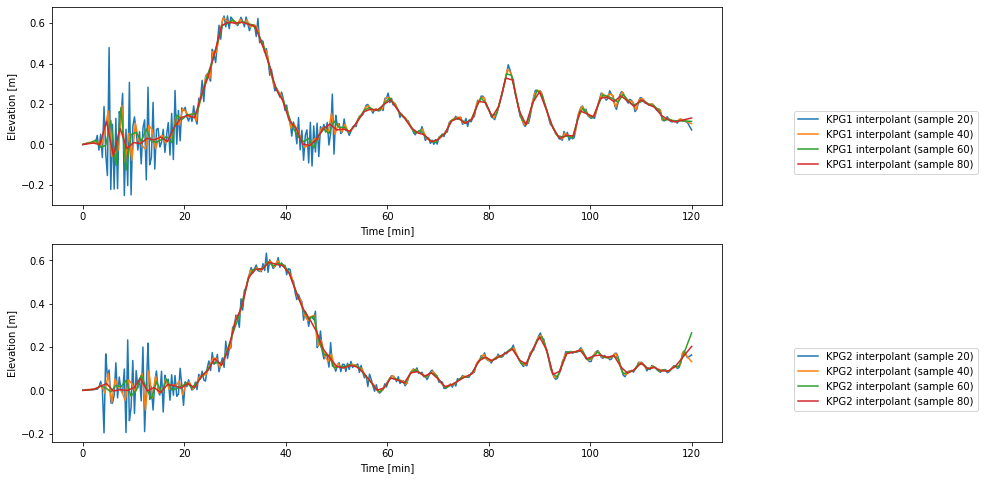

In [22]:
gauges = op.mid_field_pressure_gauges["gauges"][:2]
plot_interpolated_data(gauges, samples=[20, 40, 60, 80], plot_data=False);

### Far field pressure gauges

For these gauges the observation frequency is lower (every minute), so we don't want to do too much sampling.
We choose the arrival time to be after the pulse of the acoustic wave as we don't want to fit to that.

solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.
solve: matrix prep ... solution ... done.
prep/calcs ... done.


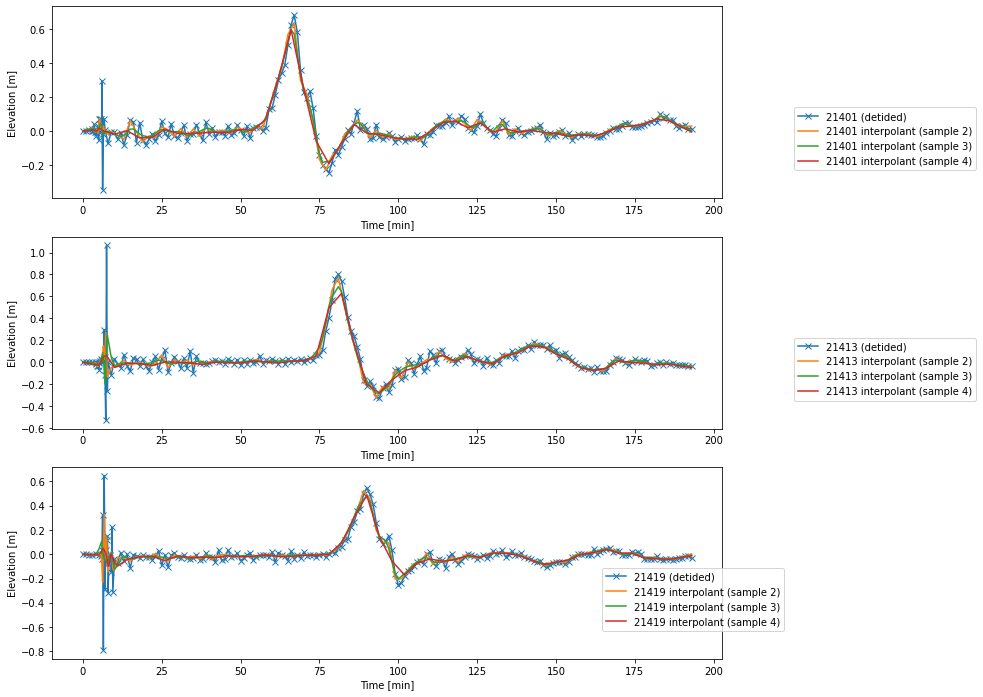

In [23]:
gauges = op.far_field_pressure_gauges["gauges"]
plot_interpolated_data(gauges, samples=[2, 3, 4]);